In [18]:
# imports and useful variables
import sys
import os
import numpy as np
import pandas as pd
import dask as dd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pylab import rcParams

from datetime import timedelta
# from statsmodels.tsa.forecasting.stl import STLForecast
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format
sns.set_style("whitegrid")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"
consumption_train = pd.read_parquet(data_path+"/05_model_input/"+"consumption_train")
pressure_train = pd.read_parquet(data_path+"/05_model_input/"+"pressure_train")
print(os.listdir(data_path + "/05_model_input"))
consumption_train.head(2)
# consumption_train.shape
# pressure_train.shape
# consumption_train[consumption_train.duplicated()]
# pressure_train[pressure_train.duplicated()]

print(pressure_train.n_working_compressors.value_counts())

consumption_train_pressure = consumption_train[
    ["time", "max_pressure_Bars", "n_working_compressors"]
].copy()
consumption_train_pressure.set_index("time", inplace=True)
consumption_train_pressure = consumption_train_pressure.resample("H").max().copy()
consumption_train_pressure.reset_index(inplace=True)
consumption_train = consumption_train[
    [
        "time",
        "total_average_power_consumption_kW_nodes",
        "total_average_power_consumption_kW_chillers",
        "Temperature_In_Degrees",
        "Temperature_Out_Degrees",
        "Temperature_Ambient_Degrees",
        "Temperature_Evaporator_Degrees",
    ]
].copy()

consumption_train.set_index("time", inplace=True)
consumption_train = consumption_train.resample("H").mean().copy()
consumption_train.reset_index(inplace=True)
consumption_train = pd.merge(consumption_train, consumption_train_pressure, on="time")

pressure_train_pressure = pressure_train[
    ["time", "max_pressure_Bars", "n_working_compressors"]
].copy()
pressure_train_pressure.set_index("time", inplace=True)
pressure_train_pressure = pressure_train_pressure.resample("H").max().copy()
pressure_train_pressure.reset_index(inplace=True)
pressure_train = pressure_train[
    [
        "time",
        "total_average_power_consumption_kW_nodes",
        "total_average_power_consumption_kW_chillers",
        "Temperature_In_Degrees",
        "Temperature_Out_Degrees",
        "Temperature_Ambient_Degrees",
        "Temperature_Evaporator_Degrees",
    ]
].copy()
pressure_train.set_index("time", inplace=True)
pressure_train = pressure_train.resample("H").mean().copy()
pressure_train.reset_index(inplace=True)
pressure_train = pd.merge(pressure_train, pressure_train_pressure, on="time")

pressure_train.to_parquet(data_path+"/05_model_input/"+"pressure_train_1hour")
consumption_train.to_parquet(data_path+"/05_model_input/"+"consumption_train_1hour")

['consumption_train', 'pressure_train']
1    13162
2      242
0       58
3       55
4       19
Name: n_working_compressors, dtype: int64


# 1 Estudio y forecasting del consumo de las dos enfriadoras
Se procederá a realizar el forecast suma del consumo en kW de ambas enfriadoras (considerando la suma de sus consumos medios en ventanas de 30 minutos. UPDATE: se ha hecho resample y se ha pasado a trabajar con granularidad horaria ya que, tras comentarlo con Javier, no nos enmascara de mora notable la estacionalidad diaria y reduce notablemente el dataset, haciendolo mas manejable) para 24 horas vista, (todo el dataset menos el último día como train), 7 días vista y un mes vista.

De momento como métricas de error RMSE y SMAPE (symmetric Mean Absolute Percentage Error  https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac )

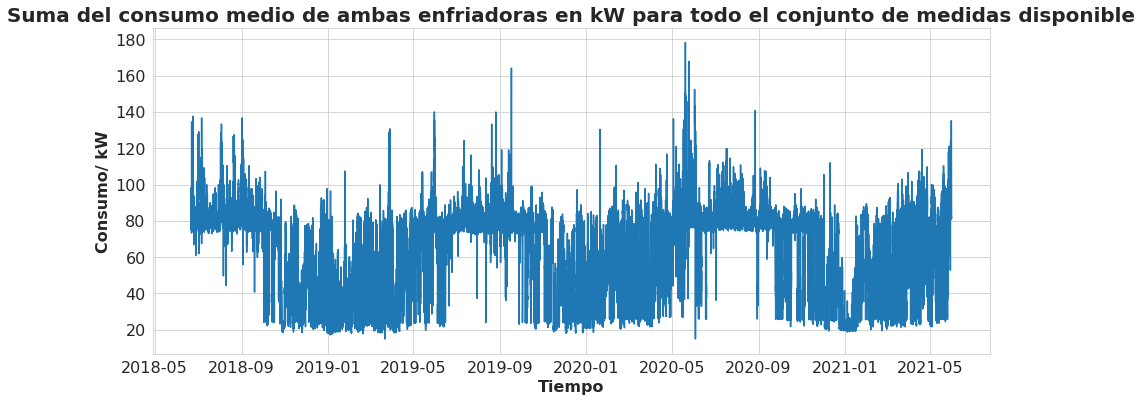

In [17]:

fig, ax = plt.subplots(figsize=(15, 6))
# sns.lineplot(
#     consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
# )
sns.lineplot(
    consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
)

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para todo el conjunto de medidas disponible",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_wholeData.svg", format="svg",dpi =600)
plt.show()
plt.close()


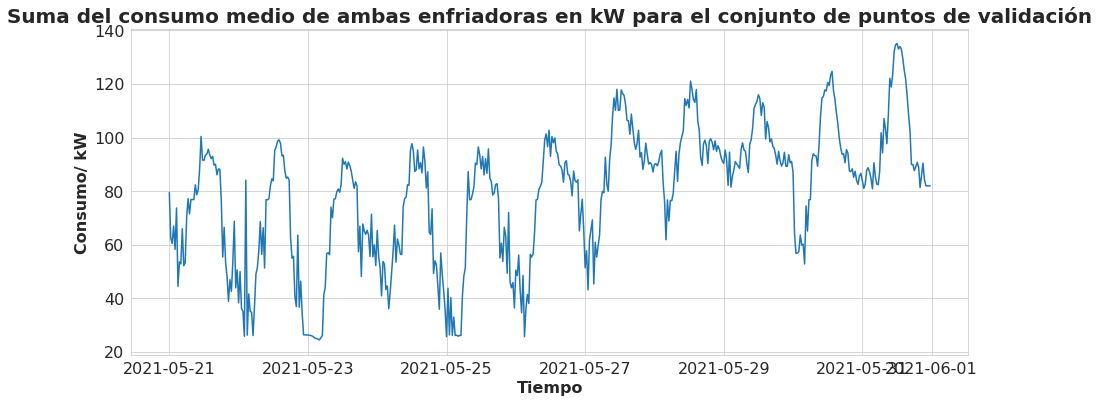

In [20]:

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")],
)
# sns.lineplot(
#     consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
# )

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para el conjunto de puntos de validación",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_validationData.svg", format="svg",dpi =600)
plt.show()
plt.close()


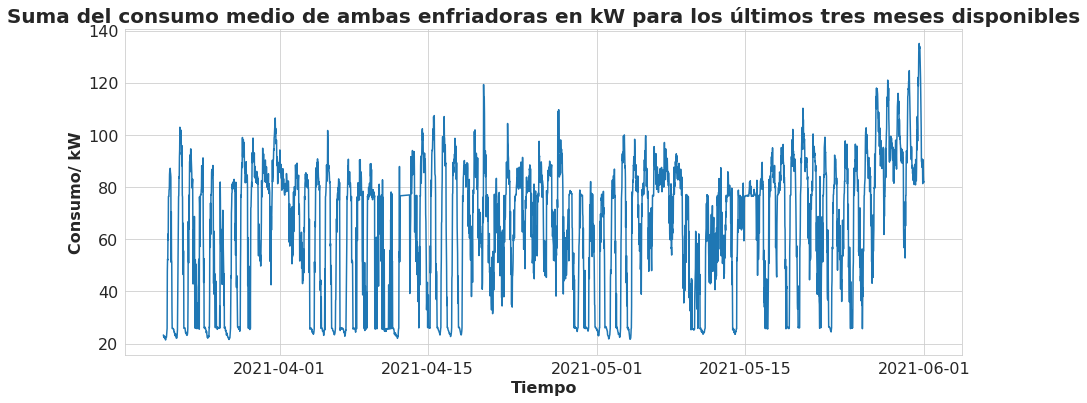

In [21]:

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"][consumption_train.time >= pd.to_datetime("2021-03-21 00:00:00")], consumption_train["total_average_power_consumption_kW_chillers"][consumption_train.time >= pd.to_datetime("2021-03-21 00:00:00")],
)
# sns.lineplot(
#     consumption_train["time"], consumption_train["total_average_power_consumption_kW_chillers"],
# )

ax.set_title(
#     "Sum of both chillers average consumption in kW during the whole available dataset",
    "Suma del consumo medio de ambas enfriadoras en kW para los últimos tres meses disponibles",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Tiempo", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Consumo/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/chiller_consumption_last3Months.svg", format="svg",dpi =600)
plt.show()
plt.close()


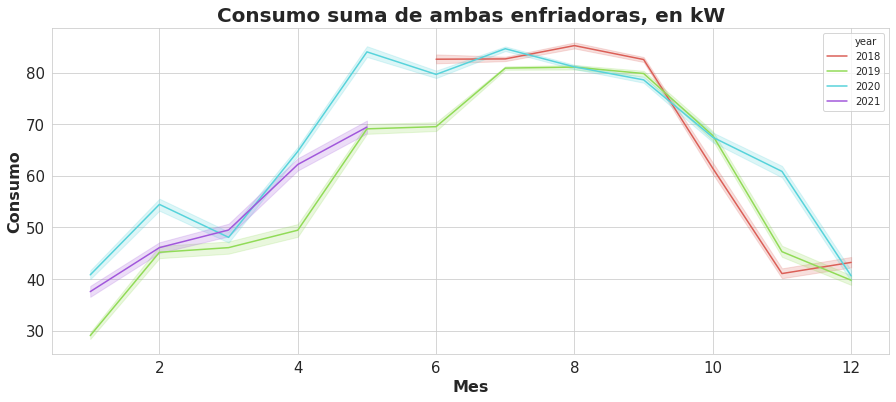

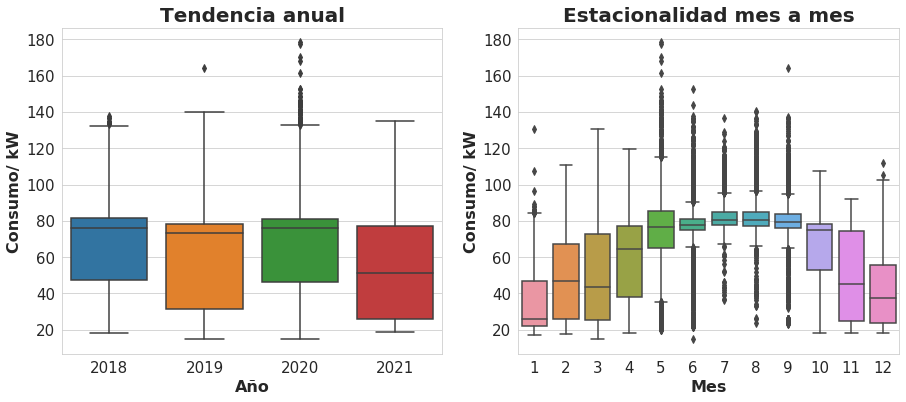

In [23]:
variable = "total_average_power_consumption_kW_chillers"
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("hls", 4)
sns.lineplot(
    consumption_train["month"],
    consumption_train[variable],
    hue=consumption_train["year"],
    palette=palette,
)
ax.set_title(
    "Consumo suma de ambas enfriadoras, en kW",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Mes", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel("Consumo", fontsize=16, fontdict=dict(weight="bold"))
plt.savefig(
    visualization_path + "/chiller_consumption_Estacionalidad.svg", bbox_inches="tight"
)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(consumption_train["year"], consumption_train[variable], ax=ax[0])
ax[0].set_title(
    "Tendencia anual", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[0].set_xlabel("Año", fontsize=16, fontdict=dict(weight="bold"))
ax[0].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))

sns.boxplot(consumption_train["month"], consumption_train[variable], ax=ax[1])
ax[1].set_title(
    "Estacionalidad mes a mes", fontsize=20, loc="center", fontdict=dict(weight="bold")
)
ax[1].set_xlabel("Mes", fontsize=16, fontdict=dict(weight="bold"))
ax[1].set_ylabel("Consumo/ kW", fontsize=16, fontdict=dict(weight="bold"))
plt.savefig(
    visualization_path + "/chiller_consumption_boxPlots.svg", bbox_inches="tight"
)
plt.show()


Similar comportamiento del consumo año a año entre las medidas disponibles. Notable cantidad de outlayers en la tendencia de 2020 (coronavirus?). Los meses de verano y mayo presentan una gran distancia entre el tercer y cuarto cuartil. También gran cantidad de puntos extremos. Esto es lógico. En verano es cuando la temperatura ambiente es mayor. De esto modo, no es posible aprovechar el Free Cooling y los compresores deben trabajar para enfriar el agua que viene caliente (18-25 grados) del CPD (Centro de Procesamiento de Datos) tras enfriar el aire de este último.

La funcion tsa.seasonal_decompose necesita recibir un ciclo si no lo puede inferir autom'aticamente del dataframe como es el caso. Usaremos la funcion de autorrelacion para estimar de forma grosera la estacionalidad y calcularemos cuantos puntos hay por ciclo estacional sabiendo que tenemos medidas cada media hora

Descomposicion aditiva ETS https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-1-dd3ea417d8c4

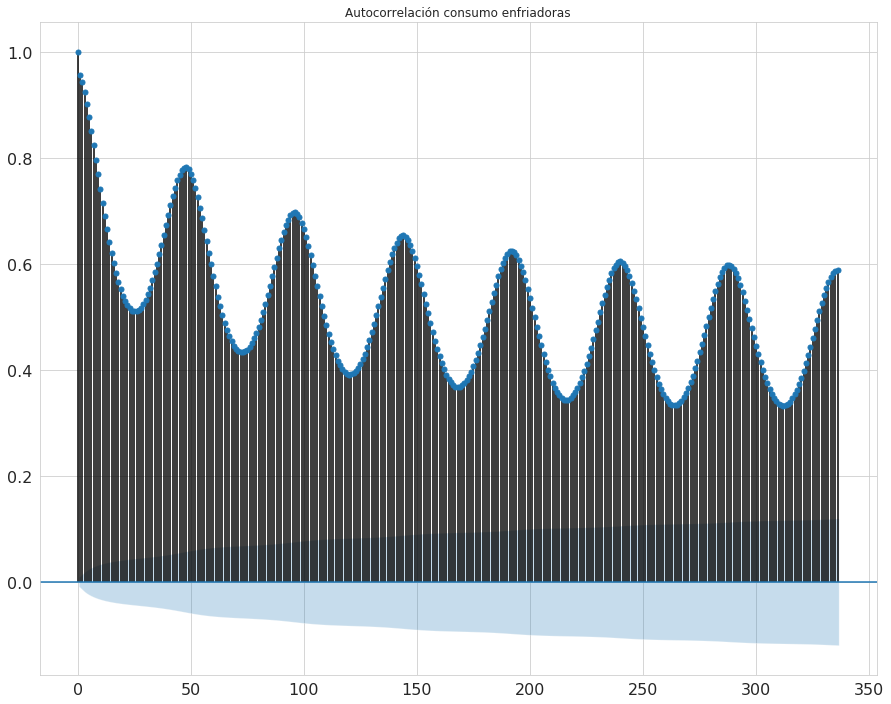

In [84]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=48*7)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

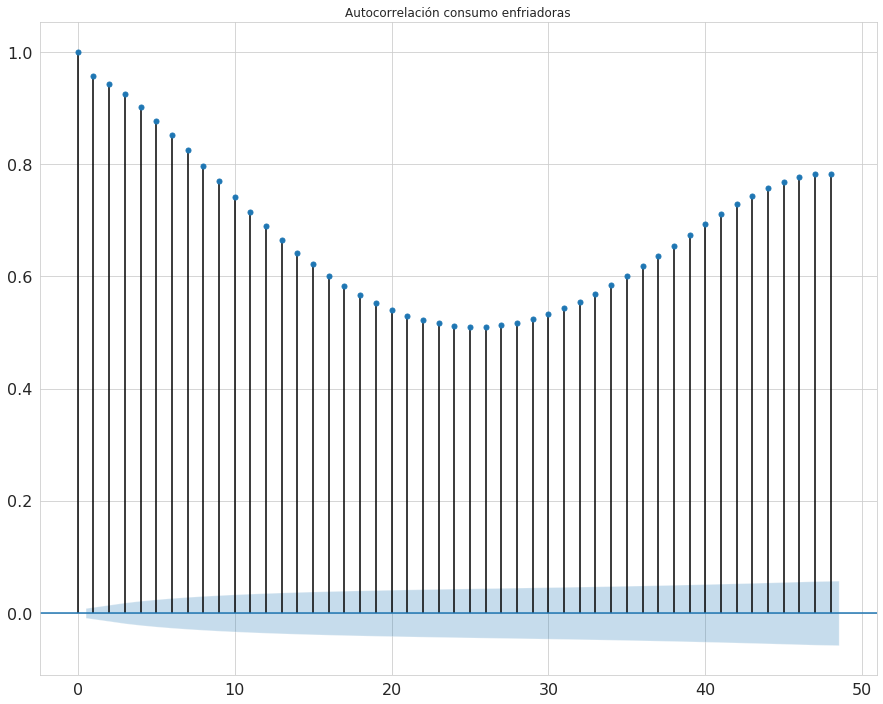

In [86]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=48)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

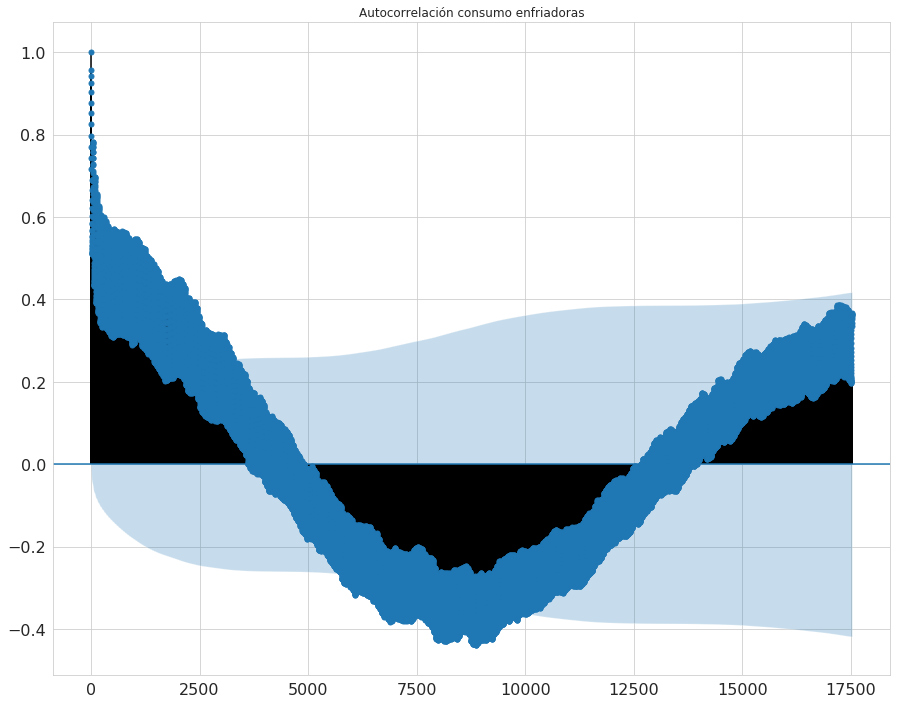

In [107]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=365*48)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

Fuerte autocorrelacion con un lag de 48*365, la serie temporal acabando en la misma fecha del año anterior. Notamos que entra en una region entre medias que parece esta en el rango del ruido blanco. Y que antes de entrar en esa regionan, en torno a 3000 puintos que son 60 dias

In [109]:
3000/48

62.5

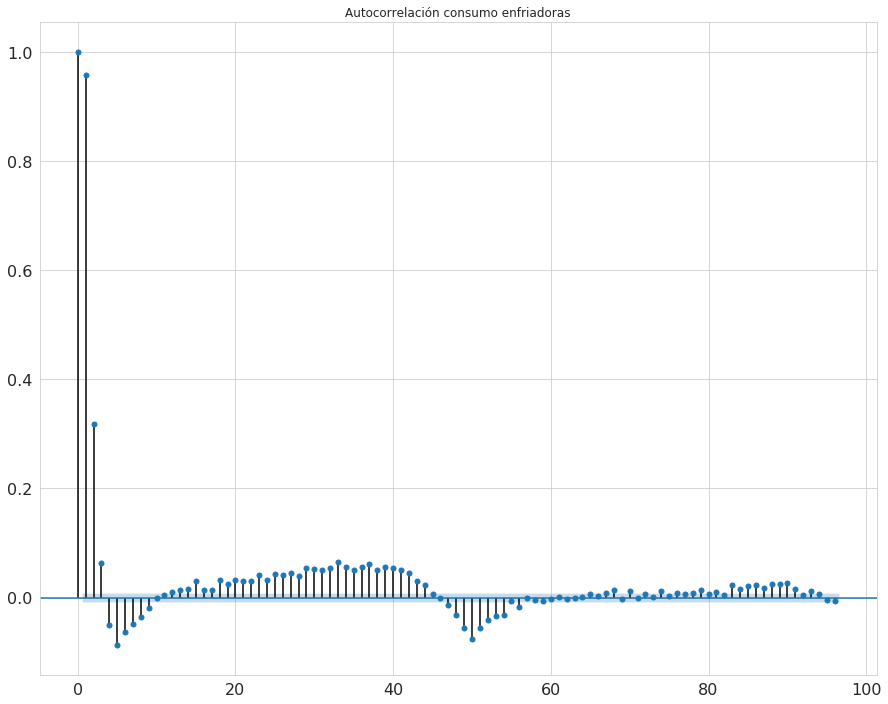

In [88]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_pacf(x, lags=96)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

KeyboardInterrupt: 

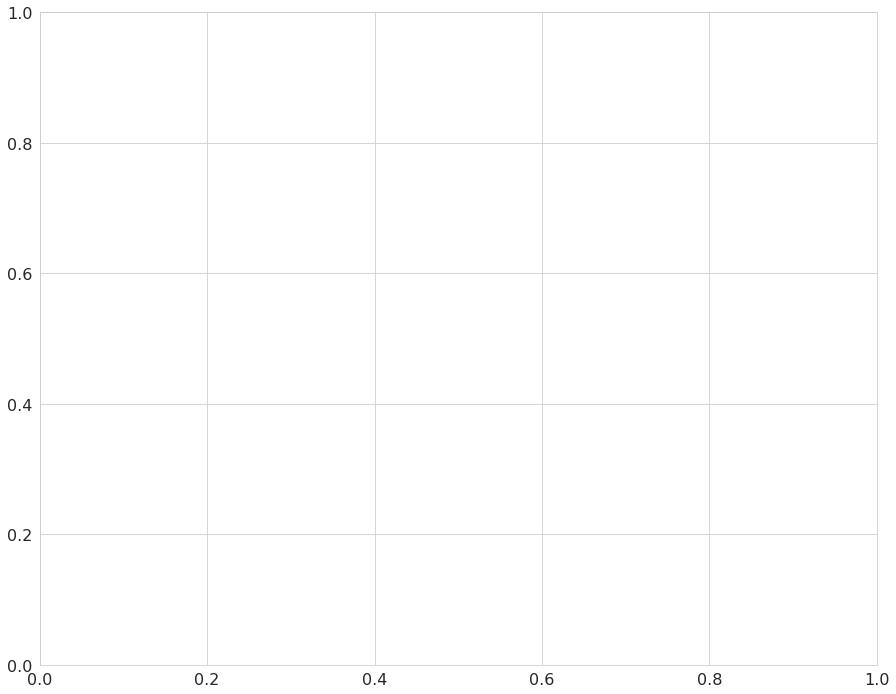

In [116]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_pacf(x, lags=48*365)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

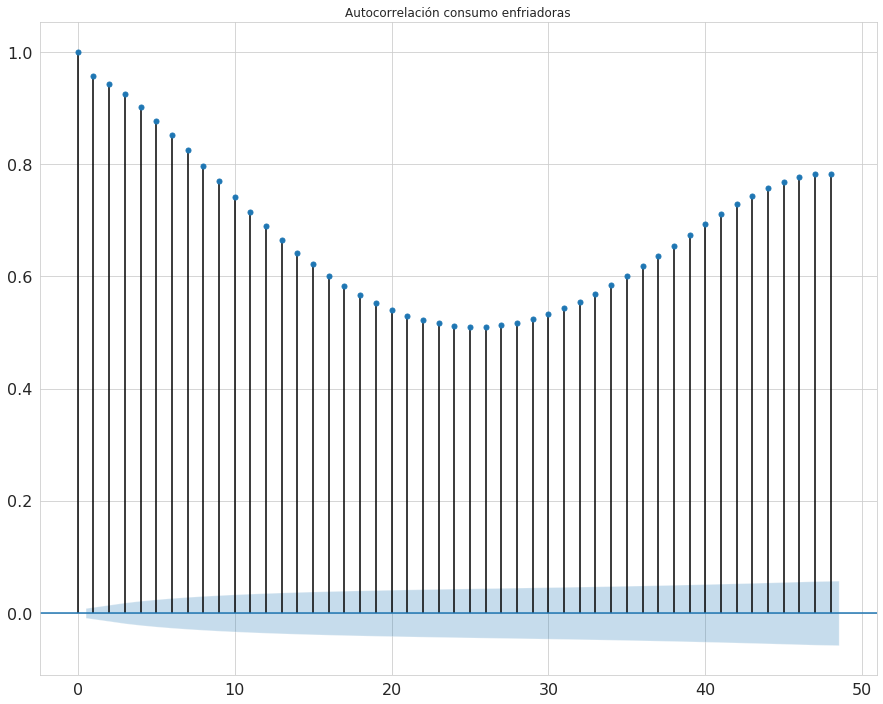

In [105]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=48)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

KeyboardInterrupt: 

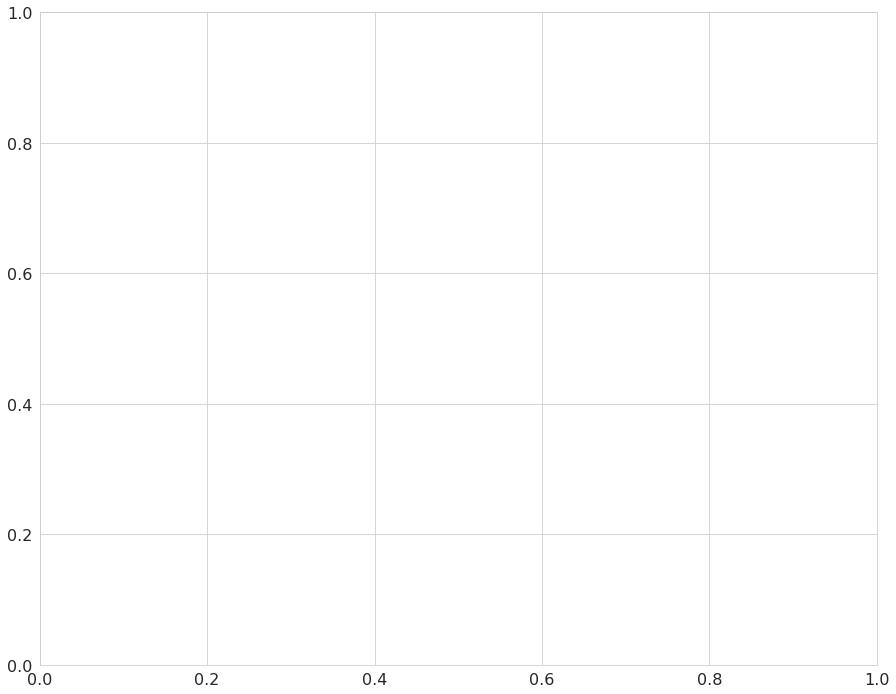

In [131]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_pacf(x, lags=np.array([48,48*7, 48*365]))
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

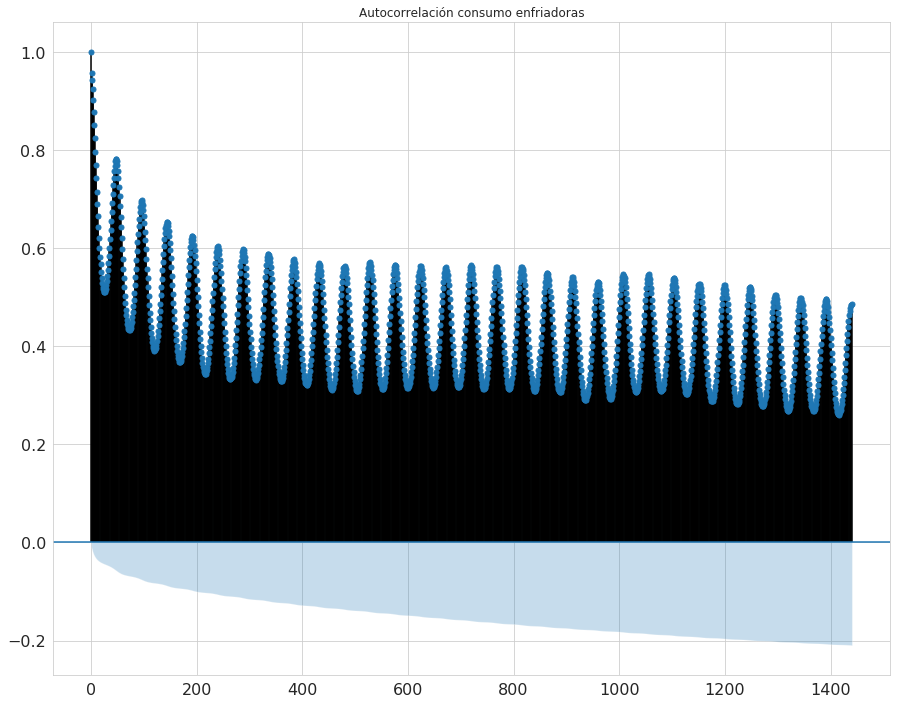

In [110]:
x=np.asarray(consumption_train.total_average_power_consumption_kW_chillers)
plot_acf(x, lags=48*30)
plt.title("Autocorrelación consumo enfriadoras")
plt.show()

Como vemos gracias a la autocorrelacion, realmente las correlaciones intermedias son cofounding variables (entre 3 y 48). El valor previo que mas impacto tiene en el posterior es el inmediatamente anterior t-1 seguido de t-2 y t-3.

Clara autocorrelacion con lag 48, medida cada 30 minutos asi que periodo estacional diario

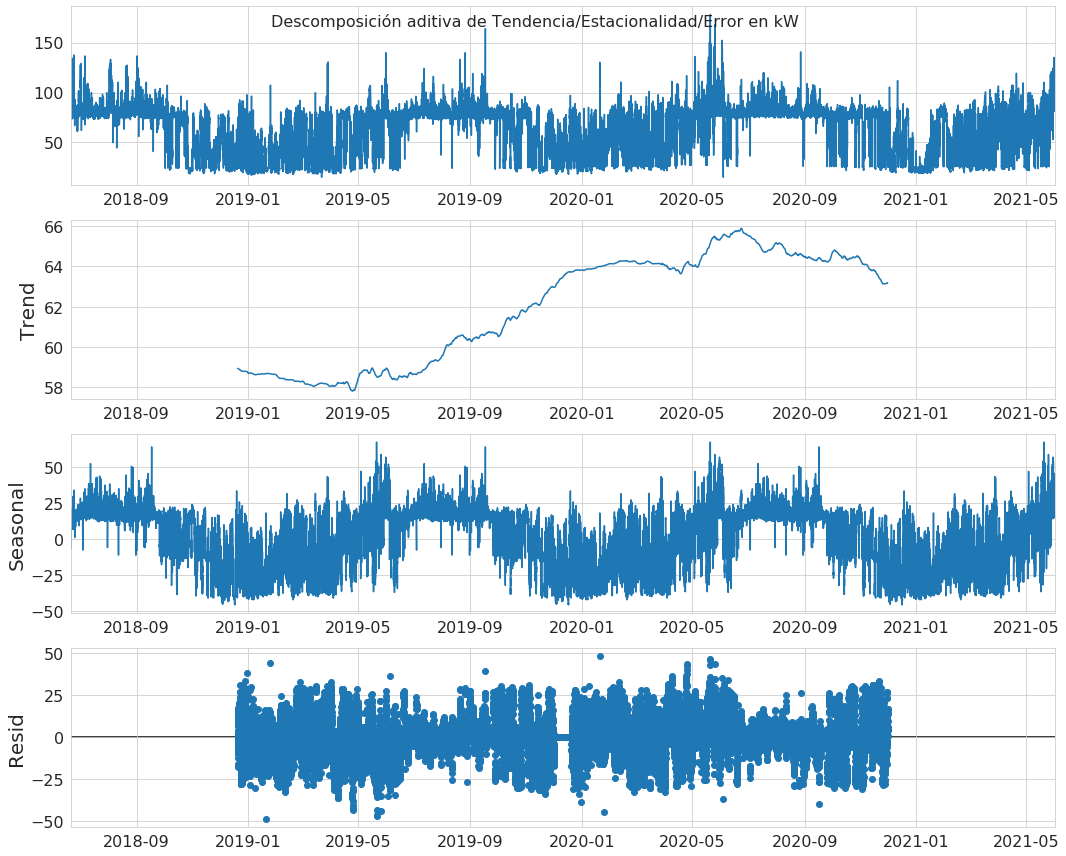

In [115]:
y = consumption_train[["time", "total_average_power_consumption_kW_chillers"]].copy()
y.time = pd.to_datetime(y.time)
y.set_index("time", inplace=True, drop=True)
# y.index.freq=pd.infer_freq(y.index)
# y=y.asfreq("30min") #T stands for minutes for some reason https://stackoverflow.com/questions/54630027/how-to-set-frequency-with-pd-to-datetime?rq=1
# y.total_average_power_consumption_kW_chillers.fillna(y.total_average_power_consumption_kW_chillers.mean(), inplace=True)
rcParams["figure.figsize"] = 15, 12
rcParams["axes.labelsize"] = 20
rcParams["ytick.labelsize"] = 16
rcParams["xtick.labelsize"] = 16
decomposition = sm.tsa.seasonal_decompose(y, period=48*365,model="additive")
decomp = decomposition.plot()
decomp.suptitle(
    "Descomposición aditiva de Tendencia/Estacionalidad/Error en kW", fontsize=16
)
decomp.savefig(
    visualization_path + "/chiller_consumption_ETS_WholeData.svg", bbox_inches="tight"
)


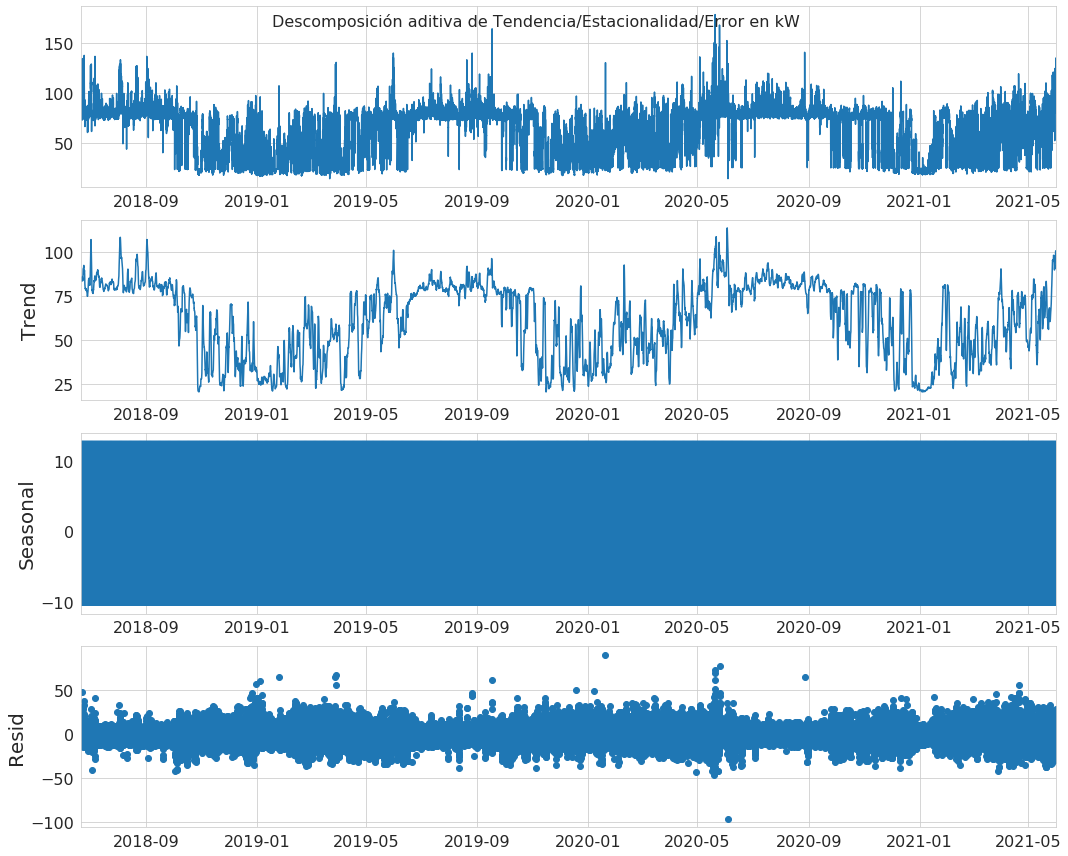

In [114]:
y = consumption_train[["time", "total_average_power_consumption_kW_chillers"]].copy()
y.time = pd.to_datetime(y.time)
y.set_index("time", inplace=True, drop=True)
# y.index.freq=pd.infer_freq(y.index)
# y=y.asfreq("30min") #T stands for minutes for some reason https://stackoverflow.com/questions/54630027/how-to-set-frequency-with-pd-to-datetime?rq=1
# y.total_average_power_consumption_kW_chillers.fillna(y.total_average_power_consumption_kW_chillers.mean(), inplace=True)
rcParams["figure.figsize"] = 15, 12
rcParams["axes.labelsize"] = 20
rcParams["ytick.labelsize"] = 16
rcParams["xtick.labelsize"] = 16
decomposition = sm.tsa.seasonal_decompose(y, period=48,model="additive")
decomp = decomposition.plot()
decomp.suptitle(
    "Descomposición aditiva de Tendencia/Estacionalidad/Error en kW", fontsize=16
)
decomp.savefig(
    visualization_path + "/chiller_consumption_ETS_WholeData.svg", bbox_inches="tight"
)


La mayor cantidad de estacionalidad "Explicada se obtiene" con un ciclo de 48*365, un año

### Hoja de ruta:

Aplicar Test ADF

Mientras no sea estacionario: 
    
    Linealizar (transformaciones Box-Cox y diferenciación)

Si es estacionario:

    Calcular ACF y PACF para determinar valores p,q,d de métodos de la familia ARMA (autorregresivos).
    

In [119]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(y.total_average_power_consumption_kW_chillers)

In [120]:
test_result

(-9.78714936949117,
 6.49773072503912e-17,
 55,
 51586,
 {'1%': -3.430476771322223,
  '5%': -2.8615960303588492,
  '10%': -2.5667998231003133},
 339790.10914866906)

El p-value es menor que 0.05 (e incluso que 0.01). Podemos descartar la hipótesis nula y asumir que la serie es estacionaria, tal y como podría esperarse del caso de uso (el consumo de las enfriadoras depende de la necesidad de calentar agua, esta puede depender de forma indirecta de la demanda de los nodos del clúster a través de la temperatura del CPD, pero las dependencias directas que más peso tienen son la época del año para beneficiarse del Free Cooling o no (de ahí la estacionalidad tan marcada para lag de 48 puntos (24 horas), pero también de 48·365 (si la misma fecha del año anterior se hizo trabajar a los compresores es porque fue verano, luego ahora también))

In [124]:
test_pressure = adfuller(consumption_train.max_pressure_Bars)
test_pressure_summer = adfuller(pressure_train.max_pressure_Bars)

In [123]:
test_pressure

(-11.38310543808403,
 8.41666234201511e-21,
 56,
 51585,
 {'1%': -3.4304767737798683,
  '5%': -2.8615960314450555,
  '10%': -2.5667998236784686},
 171637.9387081332)

In [126]:
test_pressure_summer#

(-8.182580106010837,
 8.05697006291343e-13,
 41,
 13494,
 {'1%': -3.4308347001924195,
  '5%': -2.8617542147612998,
  '10%': -2.566884021651593},
 18859.589834908496)

Ambas series problema son estacionarias

ARIMA no funciona bien para series estacionarias, para eso usa SARIMAX

# Sarimax

Empezamos con la prediccion para 24 horas

In [142]:
consumption_train.head(1)

,time,total_average_power_consumption_kW_nodes,year,month,week,max_pressure_Bars,total_average_power_consumption_kW_chillers,n_working_compressors,Temperature_In_Degrees,Temperature_Out_Degrees,Temperature_Ambient_Degrees,Temperature_Evaporator_Degrees
0,2018-06-21,72.61,2018,6,25,16.30,78.30,1,15.80,15.00,17.89,15.97


In [2]:
#consumption_train[:-48*7]#Cantidad para entrenar

sarimax_model = SARIMAX(consumption_train[:-48*7].total_average_power_consumption_kW_chillers, order = (48, 0, 3), trend="c").fit()
with open(data_path+"/06_models/sarimax_consumption_48_0_3.pickle", "wb") as f: #For some reason, models in statsmodels.tsa.statespace have pending the implementation of .load()
    pickle.dump(sarimax_model, f)

KeyboardInterrupt: 

In [6]:
#Queremos predecir proximos 48 puntos
sarimax_model.predict(48)

NotImplementedError: 

In [ ]:
sm.tsa.statespace.SARIMAX